<a href="https://colab.research.google.com/github/JacPowell/QMUL-Projects/blob/main/Project/%20AE_4_Multi_morbidity_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Setting up google drive 
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks')



Mounted at /content/drive


In [2]:
import my_utils as mu
import torch
from torch import nn
import torch.utils.data as data_utils
from torch.utils.data import DataLoader, ConcatDataset
from IPython import display
import math
import torchvision
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold



In [3]:
def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

In [4]:
train_path = '/content/drive/MyDrive/Data/MM_train_data'
train_data = torch.load(train_path)
test_path = '/content/drive/MyDrive/Data/MM_test_data'
test_data = torch.load(test_path)


In [5]:
#https://github.com/bvezilic/Variational-autoencoder
import torch
import torch.nn as nn
import torch.nn.functional as F


class AE(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, latent_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, latent_size)
        self.fc5 = nn.Linear(latent_size, hidden_size3)
        self.fc6 = nn.Linear(hidden_size3, hidden_size2)
        self.fc7 = nn.Linear(hidden_size2, hidden_size1)
        self.fc8 = nn.Linear(hidden_size1, input_size)
        self.lrelu = nn.LeakyReLU(0.1)

    def encode(self, x):
        p_x = self.lrelu(self.fc1(x))
        p_x = self.lrelu(self.fc2(p_x))
        p_x = self.lrelu(self.fc3(p_x))
        p_x = self.lrelu(self.fc4(p_x))

        return p_x

    def decode(self, z_x):
        q_x = self.lrelu(self.fc5(z_x))
        q_x = self.lrelu(self.fc6(q_x))
        q_x = self.lrelu(self.fc7(q_x))
        q_x = torch.sigmoid(self.fc8(q_x))
        #q_x = q_x.round()

        return q_x

    def forward(self, x):
        p_x = self.encode(x)
        q_z = self.decode(p_x)

        return q_z, p_x

In [6]:
#https://github.com/christianversloot/machine-learning-articles/blob/main/
#how-to-use-k-fold-cross-validation-with-pytorch.md

if __name__ == '__main__':
  
  # Configuration options
  k_folds = 5
  epochs = 30
  #loss_function = nn.CrossEntropyLoss()
  loss_function = nn.MSELoss()
  
  # For fold results
  train_results = {}
  val_results = {}
  
  # Set fixed random number seed
  torch.manual_seed(42)
  
  # Prepare dataset by concatenating Train/Test part; we split later.

  dataset = ConcatDataset([test_data, train_data])
  
  # Define the K-fold Cross Validator
  kfold = KFold(n_splits=k_folds, shuffle=True)
    
  # Start print
  print('--------------------------------')

  # K-fold Cross Validation model evaluation
  for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
    
    # Print
    print(f'FOLD {fold}')
    print('--------------------------------')
    
    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
    
    # Define data loaders for training and testing data in this fold
    trainloader = torch.utils.data.DataLoader(
                      dataset, 
                      batch_size=100, sampler=train_subsampler)
    testloader = torch.utils.data.DataLoader(
                      dataset,
                      batch_size=100, sampler=test_subsampler)
    
    net = AE(input_size=204, 
          hidden_size1=192, 
          hidden_size2=128, 
          hidden_size3=64, 
          latent_size=4)
    net.apply(reset_weights)

    # create an optimizer object
    # Adam optimizer with learning rate 1e-3
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)



    # Run the training loop for defined number of epochs
    for epoch in range(1, epochs + 1):
        print(f'\n Epoch {epoch}')
        loss = 0
        training_loss = 0
        test_loss = 0
        val_latents = []
        val_outputs = []
        train_outputs = []
        for i, (batch_features) in enumerate(trainloader):
            optimizer.zero_grad()
            # Reshape data so each image is an array with 784 elements
            batch_features = batch_features.view(-1, 204)

            output, latent = net(batch_features)
            criterion = loss_function(output, batch_features)
            criterion.backward()
            optimizer.step()

            #avg_loss += loss.item()/len(train_data)

            #z, mu_e, logvar_e = net.encode(batch_features)
            #output = net.decode(z)
            
            train_outputs.append(output.detach().numpy())
            
            train_loss = loss_function(output, batch_features)
            
            # Print statistics
            loss += train_loss.item()
            training_loss += train_loss.item()
            
            

            if i % 100 == 0:
                # Print average loss per sample in batch
                batch_loss = loss/len(batch_features)
                print(f'\r[{i:d}/{len(batch_features):d}] batch loss: {batch_loss} ',
                      end='', flush=True)
            loss = 0
          

    # Process is complete.
    print('Training process has finished. Saving trained model.')

    # Print about testing
    #print('Starting testing')

    # Evaluation for this fold

    with torch.no_grad():

      # Iterate over the test data and generate predictions
      for i, (batch_features) in enumerate(testloader):

          # Reshape data so each image is an array with 784 elements
          batch_features = batch_features.view(-1, 204)

          #test_loss = net(batch_features)
          output, latent = net(batch_features)
          
          val_outputs.append(output.detach().numpy())
          val_latents.append(latent.detach().numpy())
          val_loss = loss_function(output, batch_features)




          test_loss += val_loss.item()


      train_outputs = np.concatenate( train_outputs, axis=0 )
      val_outputs = np.concatenate( val_outputs, axis=0 )
      val_latents = np.concatenate( val_latents, axis=0 )
      model_train_loss = training_loss / len(train_outputs
                        )
      test_loss = test_loss / len(val_outputs
                        )
      #animator.add(epoch, (loss, test_loss))
      #print(train_iter[0][:5])
      #print(outputs[:5])




      # Print fold loss
      print(f'Training loss for fold {fold}: {model_train_loss}')
      print(f'Validation loss for fold {fold}: {test_loss}')
      print('--------------------------------')
      train_results[fold] = model_train_loss
      val_results[fold] = test_loss
  # Print fold results
  print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
  print('--------------------------------')
  train_sum = 0.0
  val_sum = 0.0
  for key, value in train_results.items():
    print(f'Training Fold {key} Loss: {value}')
    train_sum += value
  print(f'Trainig Average Loss: {train_sum/len(train_results.items())}')
  for key, value in val_results.items():
    print(f'Validation Fold {key} Loss: {value} ')
    val_sum += value
  print(f'Vaidation Average Loss: {val_sum/len(val_results.items())}')
      
          

--------------------------------
FOLD 0
--------------------------------
Reset trainable parameters of layer = Linear(in_features=204, out_features=192, bias=True)
Reset trainable parameters of layer = Linear(in_features=192, out_features=128, bias=True)
Reset trainable parameters of layer = Linear(in_features=128, out_features=64, bias=True)
Reset trainable parameters of layer = Linear(in_features=64, out_features=4, bias=True)
Reset trainable parameters of layer = Linear(in_features=4, out_features=64, bias=True)
Reset trainable parameters of layer = Linear(in_features=64, out_features=128, bias=True)
Reset trainable parameters of layer = Linear(in_features=128, out_features=192, bias=True)
Reset trainable parameters of layer = Linear(in_features=192, out_features=204, bias=True)

 Epoch 1
[300/100] batch loss: 0.0004601648822426796 
 Epoch 2
[300/100] batch loss: 0.0004494057595729828 
 Epoch 3
[300/100] batch loss: 0.00043847884982824327 
 Epoch 4
[300/100] batch loss: 0.0004062136

In [7]:
val_outputs_df = pd.DataFrame(val_outputs)
val_latents_df = pd.DataFrame(val_latents)



In [8]:
#val_outputs_df

In [9]:
#val_latents_df 

In [10]:
val_latents_df.corr(method='pearson')

,0,1,2,3
0,1.000000,0.346332,0.236448,0.657926
1,0.346332,1.000000,0.424304,0.289786
2,0.236448,0.424304,1.000000,0.276062
3,0.657926,0.289786,0.276062,1.000000


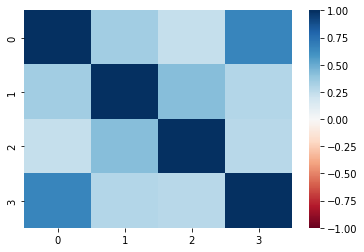

In [11]:
import matplotlib.pyplot as mp
import pandas as pd
import seaborn as sb

dataplot = sb.heatmap(val_latents_df.corr(), cmap="RdBu", vmin=-1, vmax=1)

In [12]:
val_latents_dfT = val_latents_df.transpose()

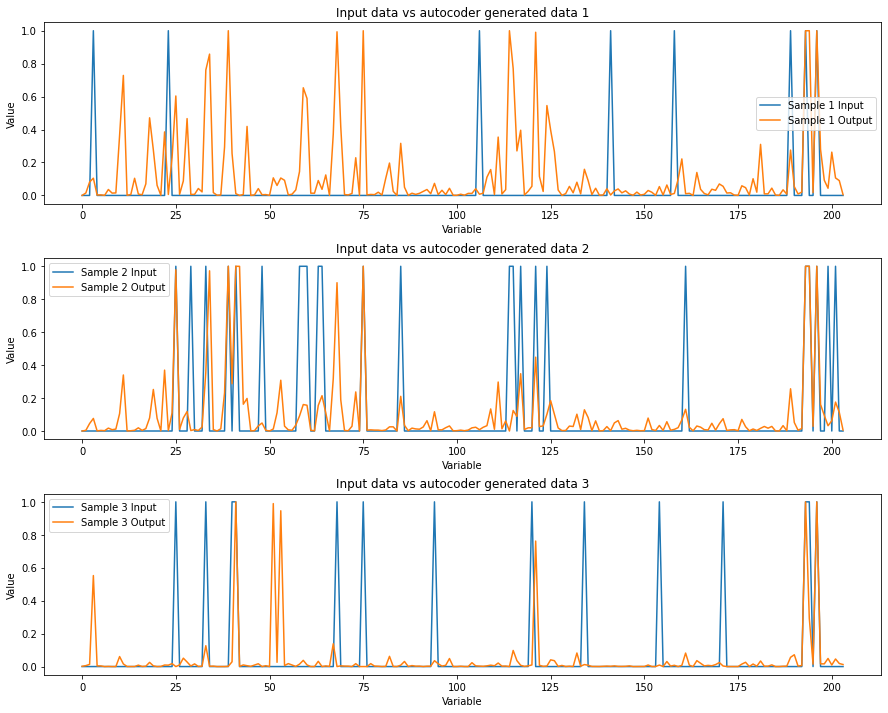

In [13]:
import matplotlib.pyplot as plt

fig, (a1, a2, a3) = plt.subplots(3, 1, figsize=(15, 12))
fig.subplots_adjust(hspace = 0.3)
a1.set_title('Input data vs autocoder generated data 1')
a1.plot(test_data[0], label = 'Sample 1 Input')
a1.plot(val_outputs[0], label = 'Sample 1 Output')
a1.set_ylabel('Value')
a1.set_xlabel('Variable')
a1.legend()

a2.set_title('Input data vs autocoder generated data 2')
a2.plot(test_data[1], label = 'Sample 2 Input')
a2.plot(val_outputs[1], label = 'Sample 2 Output')
a2.set_ylabel('Value')
a2.set_xlabel('Variable')
a2.legend()

a3.set_title('Input data vs autocoder generated data 3')
a3.plot(test_data[2], label = 'Sample 3 Input')
a3.plot(val_outputs[2], label = 'Sample 3 Output')
a3.set_ylabel('Value')
a3.set_xlabel('Variable')
a3.legend()

In [14]:

mean = val_latents.mean(axis=0)
mean = torch.from_numpy(mean)
std = val_latents.std(axis=0)
std = torch.from_numpy(std)

In [15]:
gen_lat = torch.normal(mean=mean, std=std)
data_generator = Decoder(latent_size=25, 
                        hidden_size1=150, 
                        hidden_size2=100, 
                        hidden_size3=75,
                        input_size=204 
                        )
gen_data = data_generator(gen_lat)

NameError: ignored

In [ ]:
gen_data = gen_data.detach().numpy()

In [ ]:
fig, (a1, a2, a3) = plt.subplots(3, 1, figsize=(15, 12))
fig.subplots_adjust(hspace = 0.3)
a1.set_title('Input data vs autocoder generated data 1')
a1.plot(gen_data, label = 'Sample 1 Input')
a1.plot(gen_data, label = 'Sample 1 Output')
a1.set_ylabel('Value')
a1.set_xlabel('Variable')
a1.legend()

a2.set_title('Input data vs autocoder generated data 2')
a2.plot(test_data[0], label = 'Sample 2 Input')
a2.plot(test_data[0], label = 'Sample 2 Output')
a2.set_ylabel('Value')
a2.set_xlabel('Variable')
a2.legend()